In [83]:
import torchdata
import torch
from gensim.models import FastText
import pandas as pd
import re
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt 
import seaborn as sns
import spacy
from transformers import AutoModel, AutoTokenizer

from tqdm.auto import tqdm

IGNORE_SAVED_FILES = True
print(torch.__version__, torch.cuda.is_available())
tokenizer = AutoTokenizer.from_pretrained("ai-forever/sbert_large_nlu_ru")
vectorizer = AutoModel.from_pretrained("ai-forever/sbert_large_nlu_ru")

1.12.0+cu116 True


In [2]:
with open('./../Data/anek_utf8/anek_utf8.txt', 'r', encoding='utf-8') as f:
    data = f.read()

In [3]:
data_r =  data.replace('<|startoftext|>', '').split('\n\n')

In [79]:
def print_simple_data_pipe(date_pipe: torchdata.datapipes.iter.IterDataPipe, f=lambda a: a, n=10) -> None:
  print(type(date_pipe))
  x = 0
  for sample in date_pipe:
    print(f(sample))
    if x == n:
      break
    x +=1

In [4]:
def bad_patterns_to_tags_replaser2(text: str):
    text = re.sub(r'\d+\:\d+\:\d+', ' <TIME> ', text)
    text = re.sub(r'\d+\:\d+', ' <TIME> ', text)
    text = re.sub(r'\+{,1}\d{1,3}\({,1}[\-\s]{,1}\d{3}\){,1}[\-\s]{,1}\d{3}[\-\s]{,1}\d{2}[\-\s]{,1}\d{2}', ' <PHONE> ', text)
    text = re.sub('\d+/\d+/\d+', ' <DATE> ', text)
    text = re.sub('\d+-\d+-\d+', ' <DATE> ', text)
    text = re.sub('\d+th', ' <ENUM> ', text)
    text = re.sub('\d+rd', ' <ENUM> ', text)
    text = re.sub('\d+st', ' <ENUM> ', text)
    text = re.sub('[\+\-]?\d+.\d+', ' <NUM> ', text)
    text = re.sub('[\+\-]?\d+,\d+', ' <NUM> ', text)
    text = re.sub('\d+', ' <NUM> ', text)
    # text = re.sub(r'\w+\.', '<SHORT>', text[0:-1]) + '.'
    text = re.sub(',', ' , ', text)
    text = re.sub(';', ' ; ', text)
    text = re.sub(';', ' ; ', text)
    text = re.sub('-', ' - ', text)
    text = re.sub(':', ' : ', text)
    text = re.sub('\?', ' \? ', text)
    text = re.sub('"', ' " ', text)
    text = re.sub("'", " ' ", text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub('\.', ' . ', text)
    text = re.sub('\(', ' ( ', text)
    text = re.sub('\)', ' ) ', text)
    text = re.sub('\.  \.  \.', ' ... ', text)
    text = re.sub('\s+', ' ', text)
    return text[0:-1]

In [10]:
tags = ['<SOS>', '<EOS>', '<PAD>', '<UNK>', '<NAN>', '<NUM>', '<TIME>', '<ENUM>', '<DATE>', '<PHONE>', '<EMAIL>', '<SHORT>', '<NAME>']
tags_value = pd.DataFrame({'values': [i / (1+len(tags)) for i in range(1, 1+len(tags))]}, index=tags,)
tags_value.loc['<SOS>', 'values']


0.07142857142857142

In [5]:
data_c =list(map(bad_patterns_to_tags_replaser2, data_r))

In [6]:
lengthes = np.array(list(map(lambda a: len(a.split(' ')), data_c)))


(array([ 7476., 36989., 35532., 21685., 10836.,  5528.,  2474.,   871.,
          219.,    42.]),
 array([ 2., 10., 18., 26., 34., 42., 50., 58., 66., 74., 82.]),
 <BarContainer object of 10 artists>)

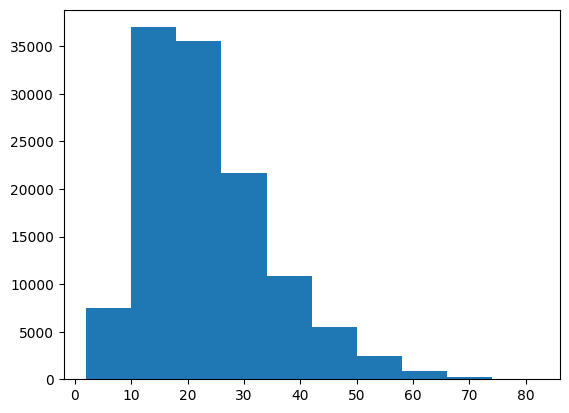

In [7]:
plt.hist(lengthes)

In [16]:
data_s = []
for i in data_c:
    data_s += i.split()
vocab = pd.Series(pd.Series(data_s).unique())
vocab = vocab[vocab.apply(lambda a: a not in tags)]
vocab = pd.concat([pd.Series(tags), vocab])

In [17]:
vocab.shape

(169524,)

# Procressing texts

In [31]:
def text_norm(text, l=30, sos='<SOS>', eos='<EOS>', pad='<PAD>'):
    text_shorted = text[0:l]
    text_padded = [sos] + text_shorted + [eos] + [pad for _ in range(l-len(text_shorted))]
    return text_padded

In [57]:
i_v = pd.Index(vocab)
def text_tokenize(text):
    return text.apply(lambda a: i_v.get_loc(a)) # [vocab[vocab==i].index[0] for i in text]


In [89]:
data_splited = pd.Series(data_c).apply(lambda a: a.split())
data_splited = data_splited[data_splited.apply(len)>15]


In [90]:
data_splited.apply(text_norm).apply(len).max(), data_splited.apply(text_norm).apply(len).min() 

(32, 32)

In [91]:
data_normed = data_splited.apply(text_norm).apply(pd.Series)
data_normed.shape[0]/34 # 17


C:\Users\Mike\AppData\Local\Temp\ipykernel_9032\1317250533.py:1: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  data_normed = data_splited.apply(text_norm).apply(pd.Series)


2534.3823529411766

In [70]:
data_normed.shape

(121652, 32)

In [72]:
for i in range(34-1):
    data_normed[i*3578:(i+1)*3578].to_csv(f'./../Data/anek_utf8/data_spited_normed_{i}.csv')

In [95]:
data_tokenize = data_normed.apply(text_tokenize)
data_tokenize.to_csv('./../Data/anek_utf8/data_tokenized.csv', index=False)

In [98]:
data_common = data_tokenize
data_common['pre'] = data_splited.apply(' '.join)
data_common.to_csv('./../Data/anek_utf8/data_common.csv', index=False)


# to torch data

In [242]:
def tokenize(sentence):
    return tokenizer([sentence], padding=True, truncation=True, pad_to_multiple_of=32, max_length=32, return_tensors='pt')

In [243]:
vocab.shape

(169524,)

In [258]:
def input_data_check_data_spliter(data):
    with torch.no_grad():
        t = torch.tensor(list(map(int, data[0:32])))
        output_data = torch.nn.functional.one_hot(t, vocab.shape[0])
        d= tokenize(data[32])
        input_data = vectorizer(**d)[0][0]
    return output_data, input_data, t


In [257]:
output_res = torchdata.datapipes.iter.IterableWrapper(['./../Data/anek_utf8/data_common.csv'])
output_res_pipe = torchdata.datapipes.iter.FileOpener(output_res, mode='r', encoding='utf-8', length=data_common.shape[0])
res_pipe = output_res_pipe.parse_csv(skip_lines=1, delimiter=',')
res_pipe = torchdata.datapipes.map.SequenceWrapper(list(res_pipe))
print_simple_data_pipe(res_pipe, n=3)


<class 'torch.utils.data.datapipes.map.utils.SequenceWrapperMapDataPipe'>
['0', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '18', '27', '18', '28', '29', '30', '18', '31', '32', '18', '33', '34', '35', '36', '18', '24', '1', 'Сразу после окончания Прямой линии , Путин пожаловался на дефицит интересных и актуальных вопросов , отметив , что критическое положение , слава богу , спасли осмысленные вопросы Шнурова , и очень своевременно поднятый вопрос о ситуации с Дзюбой .']
['0', '56', '49', '57', '45', '58', '59', '60', '24', '61', '62', '21', '63', '64', '65', '18', '66', '67', '68', '69', '68', '45', '70', '28', '71', '72', '67', '68', '73', '74', '18', '1', 'Толкучка в атобусе . Автобус резко тормозит и женщина падает на рядом седящего свещеника , восклицает : " Ого! " . На что свещеник отвечает : " Не ого , а ключ от храма " .']
['0', '79', '18', '80', '81', '82', '18', '28', '83', '84', '85', '86', '49', '87', '88', '49', '89', '90', '1', '2',

In [259]:
ready = res_pipe.map(input_data_check_data_spliter)
print_simple_data_pipe(ready, n=3, f=lambda a: (a[0].shape, a[1].shape, a[2].shape))

<class 'torch.utils.data.datapipes.map.callable.MapperMapDataPipe'>
(torch.Size([32, 169524]), torch.Size([32, 1024]), torch.Size([32]))
(torch.Size([32, 169524]), torch.Size([32, 1024]), torch.Size([32]))
(torch.Size([32, 169524]), torch.Size([32, 1024]), torch.Size([32]))
(torch.Size([32, 169524]), torch.Size([32, 1024]), torch.Size([32]))


In [260]:
def join(batch):
    d1, d2, d3 = [], [], []
    for i, j, k in batch:
        d1.append(i.unsqueeze(0))
        d2.append(j.unsqueeze(0))
        d3.append(k.unsqueeze(0))
    return torch.concat(d1), torch.concat(d2), torch.concat(d3)

In [261]:
res = torchdata.datapipes.map.Batcher(torchdata.datapipes.map.Shuffler(ready), batch_size=32)

# Make model

In [249]:
device = 'cuda'

In [253]:
class Attention(torch.nn.Module):
    def __init__(self, emb_size, n_heads):
        super(Attention, self).__init__()
        self.n_heads = n_heads
        self.wQ = (torch.nn.parameter.Parameter(torch.rand([n_heads, emb_size, emb_size])).to(device))
        self.wK = torch.nn.parameter.Parameter(torch.rand([n_heads, emb_size, emb_size])).to(device)
        self.wV = torch.nn.parameter.Parameter(torch.rand([n_heads, emb_size, emb_size])).to(device)
        self.wO = torch.nn.parameter.Parameter(torch.rand([n_heads * emb_size, emb_size])).to(device)

    def forward(self, en_out):
        eo = en_out.clone()
        for i in range(eo.shape[0]):
            m = eo[i].unsqueeze(0)
            eo[i] = self.iteration(m, m, m)
        return eo

    def iteration(self, Q: torch.tensor, K: torch.tensor, V: torch.tensor):
        d = Q.shape[2]
        s = Q.shape[1]
        qp = Q.repeat(self.n_heads, 1, 1).bmm(self.wQ)
        kp = K.repeat(self.n_heads, 1, 1).bmm(self.wK)
        vp = V.repeat(self.n_heads, 1, 1).bmm(self.wV)
        res = torch.softmax(qp.bmm(kp.transpose(1, 2))/d**0.5, 1)
        res2 = (res.bmm(vp))
        return res2.view(s, d * self.n_heads).mm(self.wO)

att = Attention(128, 4).to(device)

In [252]:
class Decoder(torch.nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, output_size):
    super(Decoder, self).__init__()
    self.input_size = input_size
    self.embedding_size = embedding_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.output_size = output_size
    self.tag = True
    self.embedding = torch.nn.Embedding(self.input_size, self.embedding_size)
    self.GRU = torch.nn.GRU(self.embedding_size, hidden_size, num_layers)
    self.fc = torch.nn.Linear(self.hidden_size, self.output_size)

  def forward(self, x, hidden_state):
    x = x.unsqueeze(0)
    embedding = self.embedding(x)
    outputs, hidden_state = self.GRU(embedding, hidden_state)
    predictions = self.fc(outputs)
    predictions = predictions.squeeze(0)
    return predictions, hidden_state

input_size_decoder = len(vocab)
decoder_embedding_size = 256
hidden_size = 1024
num_layers = 2
output_size = len(vocab)

decoder_gru = Decoder(input_size_decoder, decoder_embedding_size, hidden_size, num_layers, output_size).to(device)
print(decoder_gru)

Decoder(
  (embedding): Embedding(169524, 256)
  (GRU): GRU(256, 1024, num_layers=2)
  (fc): Linear(in_features=1024, out_features=169524, bias=True)
)


In [ ]:
class Seq2Seq(torch.nn.Module):
  def __init__(
    self, 
    input_vocab_size,
    output_vocab_size,
    decoder_embedding_size,
    position_coording_matrix,
    Decoder, 
    # Attention
  ):
    super(Seq2Seq, self).__init__()
    self.input_vocab_size = input_vocab_size
    self.output_vocab_size = output_vocab_size
    self.encoder_embedding_size = encoder_embedding_size
    self.decoder_embedding_size = decoder_embedding_size
    self.position_coording_matrix = position_coording_matrix
    self.encoder_embeder = torch.nn.Embedding(self.input_vocab_size, self.encoder_embedding_size)
    self.decoder_embeder = torch.nn.Embedding(self.output_vocab_size, self.decoder_embedding_size)
    self.Decoder = Decoder
    # self.attention = Attention

  def forward(self, source, target, tfr=0.2):
    source = source.transpose(0, 1)
    target = target.transpose(0, 1)
    batch_size = source.shape[1]
    target_len = target.shape[0]
    target_vocab_size = self.output_vocab_size
    outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
    hidden_state_encoder = source
    x = target[0,:]
    for i in range(1, target_len):
      inDec = self.decoder_embeder(x.unsqueeze(0))
      output, _ = self.Decoder(inDec, hidden_state_encoder)
      outputs[i] = output
      best_guess = output.argmax(1)
      x = target[i] if np.random.random() < tfr else best_guess
    return outputs.transpose(0, 1)


input_size_decoder = len(vocab)
encoder_embedding_size = 128
decoder_embedding_size = 128
model = Seq2Seq(input_size_encoder, input_size_decoder, encoder_embedding_size, decoder_embedding_size, position_coording_matrix, encoder_lstm, decoder_lstm, 
                # att
                ).to(device)


# Tests

In [262]:
for batch in res:
    y_b, x_b, t_b = join(batch)
    break

In [239]:
decoder_gru(t_b.to(device), x_b.to(device))

KeyboardInterrupt: 